In [8]:
import pandas as pd
import random
import math
import datetime

from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, spectral_clustering, SpectralClustering
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from numpy.random import normal
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [9]:
mnist = pd.read_csv('mnist_train.csv')

In [8]:
def get_B_and_weight_vec(matrix,threshold):
    N = matrix.shape[0]
    A = np.copy(matrix)

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshold: 
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec

In [10]:

def algorithm(B, weight_vec, seeds, K=15000, alpha=0.01, lambda_nLasso=None, check_s=False):
    E, N = B.shape
#     weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5
    samplingset = seeds

    seednodesindicator= np.zeros(N)
    seednodesindicator[samplingset] = 1
    
    
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0
    
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    if check_s:
        s = 0.0
        for item in range(len(weight_vec)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += weight_vec[item]
            elif i >= N1 > j:
                s += weight_vec[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / (1 + Gamma_vec[samplingset])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history
    
    

# image custering on MNIST dataset: 2 clusters

In [98]:
mnist_3 = mnist[mnist['label']==3].iloc[:100,:]

mnist_1 = mnist[mnist['label']==1].iloc[:100,:]

digits=mnist_3.append(mnist_1)
digits = digits.sample(frac=1,random_state=42).reset_index(drop=True)

In [104]:
digits.head(10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


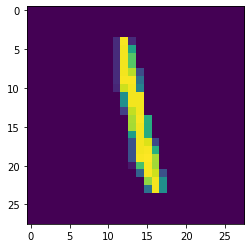

In [100]:
plt.imshow(digits.iloc[5,1:].values.reshape(28,28))

## Apply T-sne first and then generate adjecency matrix with Spectral Clustering

In [182]:
true_labels = np.array([0 if i==3 else 1 for i in digits.label])

tsne = TSNE(n_components=2)
X = tsne.fit_transform(digits.iloc[:,1:])

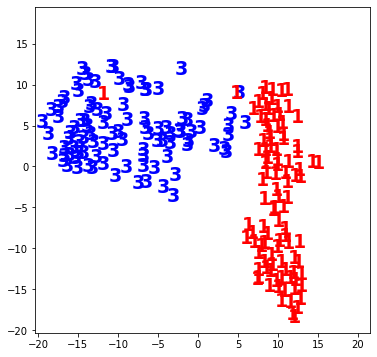

In [183]:
colors=['b',"r",'b','b','b','b','b','b','b','b']
plt.figure(figsize=(6,6))
plt.xlim(X[:,0].min(),X[:,1].max()+10)
plt.ylim(X[:,0].min(),X[:,1].max()+8)
for i in range(200):
    plt.text(X[i,0],X[i,1],str(digits.label[i]),color=colors[digits.label[i]],fontdict={'weight':'bold','size':19})

In [184]:
def run_digit(affinity_matrix, threshold,seeds, K=1000, alpha=0.01, lambda_nLasso=0.1):
#     points = get_spirals(N1, N2)
    A,B, weight_vec = get_B_and_weight_vec(affinity_matrix,threshold)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec,seeds, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)
    
    start = datetime.datetime.now()
    spectral_labels = spectral_clustering(affinity_matrix,n_clusters=2)
    print ('spectral clustering time: ', datetime.datetime.now() - start)
    print(affinity_matrix.mean())
    return history,spectral_labels

In [185]:
Affinity_Matrix=SpectralClustering(2).fit(X).affinity_matrix_
print(Affinity_Matrix.mean())

0.010189597974677684


In [186]:
num_seeds = 0.2*100
seeds = np.random.choice(np.argwhere(digits.label.values==1).squeeze(),int(num_seeds))
history,spectral_labels = run_digit(Affinity_Matrix,threshold=0.015,K=300, seeds=seeds, \
                                    alpha=0.02, lambda_nLasso=0.1)
# history[-1]

our method time:  0:00:00.042376
spectral clustering time:  0:00:00.140287
0.010189597974677684


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


In [187]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(np.nan_to_num(history[-1].reshape(-1,1)))
if sum(kmeans.labels_ == true_labels) >= 100:
    print('our method accuracy: ', sum(kmeans.labels_ == true_labels)/len(true_labels))
else:
    print('our method accuracy: ', (len(true_labels)-sum(kmeans.labels_ == true_labels))/len(true_labels))

if sum(spectral_labels == true_labels) >= 100:
    print('spectral clustering accuracy: ', sum(spectral_labels== true_labels)/len(true_labels))
else:
    print('spectral clustering accuracy: ', (len(true_labels)-sum(spectral_labels == true_labels))/len(true_labels))
    

our method accuracy:  0.97
spectral clustering accuracy:  0.955


## generate adjacency matrix from high dimentional space based on neighbor probabilty

In [195]:
from numpy.linalg import norm
weig_mat_prob = np.zeros((200,200))    #adjacency matrix based on neighbor probabilty.
for i in range(200):
    for j in range(200):
        if i == j:
            continue
        weig_mat_prob[i][j]=np.exp(-norm(digits.iloc[i,1:]-digits.iloc[j,1:])/1000)
        

In [189]:
weig_mat_prob.mean()

0.11861503675131009

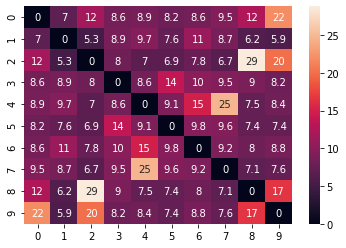

In [190]:
from seaborn import heatmap
heatmap((weig_mat_prob*100)[20:30,20:30],annot=True)

In [191]:
def run_digit(matrix, threshold,K=1000, seeds=seeds, alpha=0.2, lambda_nLasso=0.1):
#     points = get_spirals(N1, N2)
    A,B, weight_vec = get_B_and_weight_vec(matrix,threshold)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec,seeds = seeds, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)
    
    start = datetime.datetime.now()
    spectral_labels = spectral_clustering(matrix,n_clusters=2)
#     spectral_labels = SpectralClustering(2).fit(digits.iloc[:,1:]).labels_
    print ('spectral clustering time: ', datetime.datetime.now() - start)
    
    return history,spectral_labels

In [193]:
num_seeds = 0.2*100
seeds = np.random.choice(np.argwhere(digits.label.values==1).squeeze(),int(num_seeds))
history,spectral_labels = run_digit(weig_mat_prob,threshold=0.2,K=300, seeds=seeds, \
                                    alpha=0.01, lambda_nLasso=0.1)
# history[-1]

our method time:  0:00:00.053666
spectral clustering time:  0:00:00.062417


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


In [194]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(np.nan_to_num(history[-1].reshape(-1,1)))
if sum(kmeans.labels_ == true_labels) >= 100:
    print('our method accuracy: ', sum(kmeans.labels_ == true_labels)/len(true_labels))
else:
    print('our method accuracy: ', (len(true_labels)-sum(kmeans.labels_ == true_labels))/len(true_labels))

if sum(spectral_labels == true_labels) >= 100:
    print('spectral clustering accuracy: ', sum(spectral_labels== true_labels)/len(true_labels))
else:
    print('spectral clustering accuracy: ', (len(true_labels)-sum(spectral_labels == true_labels))/len(true_labels))
    

our method accuracy:  0.975
spectral clustering accuracy:  0.9


# image clustering on MNIST: 3 clusters

In [1424]:
mnist_5 = mnist[mnist['label']==5].iloc[:100,:]
mnist_0 = mnist[mnist['label']==0].iloc[:100,:]
mnist_6 = mnist[mnist['label']==6].iloc[:100,:]
digit056 = mnist_0.append(mnist_5,ignore_index=True).append(mnist_6,ignore_index=True)


In [1425]:
true_labels = np.array([i for i in range(100)])

tsne = TSNE(n_components=2)
X056 = tsne.fit_transform(digit056.iloc[:,1:])

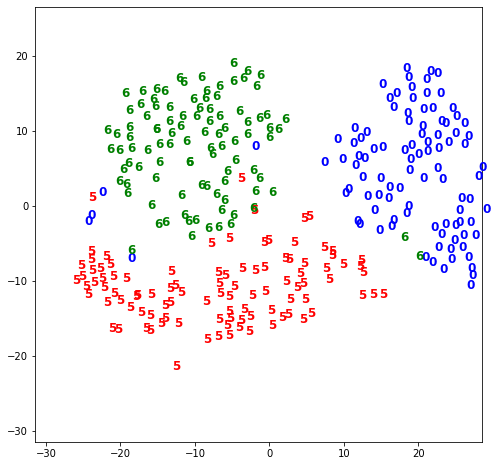

In [1709]:
colors=['b','b','b','b','b','r','g','b','b','b']
plt.figure(figsize=(8,8))
plt.xlim(X056[:,0].min()-5,X056[:,1].max()+10)
plt.ylim(X056[:,0].min()-5,X056[:,1].max()+8)
for i in range(300):
    plt.text(X056[i,0],X056[i,1],str(digit056.label[i]),color=colors[digit056.label[i]],\
             fontdict={'weight':'bold','size':12})

In [1723]:
import random
import math
import itertools
import numpy as np
from sklearn.cluster import spectral_clustering, SpectralClustering
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

n_samples = 6000

def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)

def get_B_and_weight_vec_digits(matrix):
    A = np.copy(matrix)
    N = matrix.shape[0]

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < 0.002:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return B, weight_vec


def run_multi_digits(matrix, true_labels, K, alpha, lambda_nLasso,n_clusters, M=0.2):
    B, weight_vec = get_B_and_weight_vec_digits(matrix)
    E,N=B.shape[0],B.shape[1]

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]
    lambda_weight = lambda_nLasso * weight_vec

    our_labels = np.full(N, n_clusters-1)
    our_time = datetime.datetime.now() - datetime.datetime.now()
    for clust_num in range(n_clusters-1):

        samplingset = random.choices(np.where(true_labels==clust_num)[0], k=int(M * len(np.where(true_labels==clust_num)[0])))
        seednodesindicator = np.zeros(N)
        seednodesindicator[samplingset] = 1
        noseednodeindicator = np.ones(N)
        noseednodeindicator[samplingset] = 0


        hatx = np.zeros(N)
        newx = np.zeros(N)
        prevx = np.zeros(N)
        haty = np.array([x / (E - 1) for x in range(0, E)])
        gamma_plus = 1 + Gamma_vec[samplingset]
        start = datetime.datetime.now()
        for iterk in range(K):
            tildex = 2 * hatx - prevx
            newy = haty + Sigma * B.dot(tildex)  # chould be negative
            res = abs(newy) / lambda_weight
            res[res < 1] = 1
            haty = newy / res

            newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

            newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

            newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
            prevx = np.copy(hatx)
            hatx = newx  # could be negative
        our_time += datetime.datetime.now() - start
        X = newx
        X = np.nan_to_num(X, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
        matched_label = kmeans.labels_[samplingset][0]
        our_labels[np.where(kmeans.labels_ == matched_label)[0]] = clust_num

    print ('our time is:', our_time)
    print ('our accuracy is:', accuracy(our_labels, true_labels))
    
    start = datetime.datetime.now()
    labels = spectral_clustering(matrix, n_clusters=3,random_state=1)
#     labels = SpectralClustering(3).fit(X056).labels_
    print ('spectral clustering time is:', datetime.datetime.now() - start)
    print ('spectral clustering accuracy is:', accuracy(labels, true_labels))
    



In [1736]:
Affinity_Matrix = SpectralClustering(3,random_state=1).fit(X056).affinity_matrix_
true_labels = np.array([0 for i in range(100)] + [1 for i in range(100)] + [2 for i in range(100)])
run_multi_digits(matrix=Affinity_Matrix,true_labels=true_labels, K=300,\
                 alpha=0.005, lambda_nLasso=0.8,n_clusters=3)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in multiply
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in multiply


our time is: 0:00:00.084009
our accuracy is: 0.8533333333333334
spectral clustering time is: 0:00:08.140352
spectral clustering accuracy is: 0.77
